In [8]:
# Install packages if needed with this command: 
# !pip install -r requirements.txt
import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# From here, add any libraries that you might need for the rest of your code
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, f1_score, recall_score
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import scipy.ndimage
from skimage.filters import median, laplace
from skimage.morphology import disk
from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_wavelet, calibrate_denoiser
from skimage import img_as_float, transform, exposure, io, util
from skimage.metrics import peak_signal_noise_ratio as psnr

In [56]:
data_dir = 'driver-inattention-detection-dataset'

## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f: 
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f: 
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]), 
                                label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f: 
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]), 
                               label=classes[int(line.strip()[-1])]) for line in f)
    
with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f: 
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]), 
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')


Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


[[[[ 1.13950141e-01]
   [ 1.39043517e-02]
   [ 2.12403074e-01]
   ...
   [ 4.97514427e-01]
   [ 2.44070783e-01]
   [ 3.70760500e-01]]

  [[ 1.04179822e-01]
   [ 2.41770327e-01]
   [ 4.67504635e-02]
   ...
   [ 4.68215376e-01]
   [ 3.02424371e-01]
   [ 5.44039369e-01]]

  [[-7.12325051e-02]
   [-5.77149279e-02]
   [-1.64916456e-01]
   ...
   [ 4.66280878e-01]
   [ 3.44937772e-01]
   [ 3.11778247e-01]]

  ...

  [[ 9.88480002e-02]
   [ 1.55854434e-01]
   [ 2.82973945e-02]
   ...
   [ 3.59742403e-01]
   [ 2.44698256e-01]
   [ 2.92000175e-01]]

  [[ 1.07211016e-01]
   [-1.67394370e-01]
   [ 8.46985877e-02]
   ...
   [ 2.84223378e-01]
   [ 2.56651551e-01]
   [ 1.73207581e-01]]

  [[ 2.01662675e-01]
   [ 2.30642155e-01]
   [ 1.48853585e-01]
   ...
   [ 3.11354458e-01]
   [ 6.01477176e-03]
   [ 2.99557954e-01]]]


 [[[-1.48335293e-01]
   [ 4.62097228e-02]
   [-1.11915462e-04]
   ...
   [ 3.26114237e-01]
   [ 2.72066265e-01]
   [-2.42018119e-01]]

  [[-9.66518931e-03]
   [ 8.59418735e-02]
   [

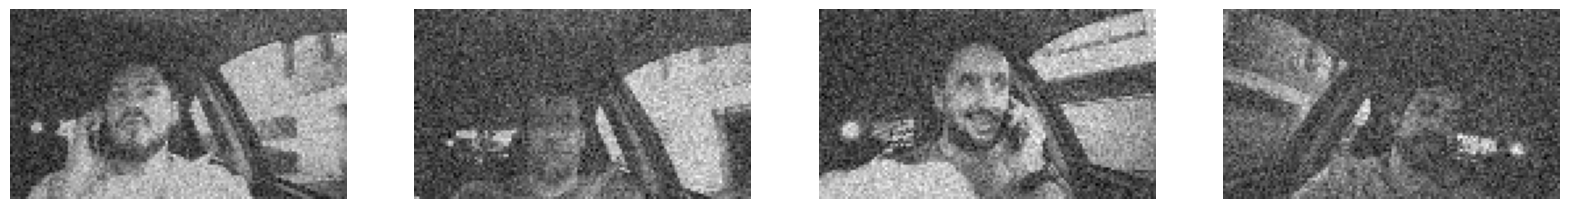

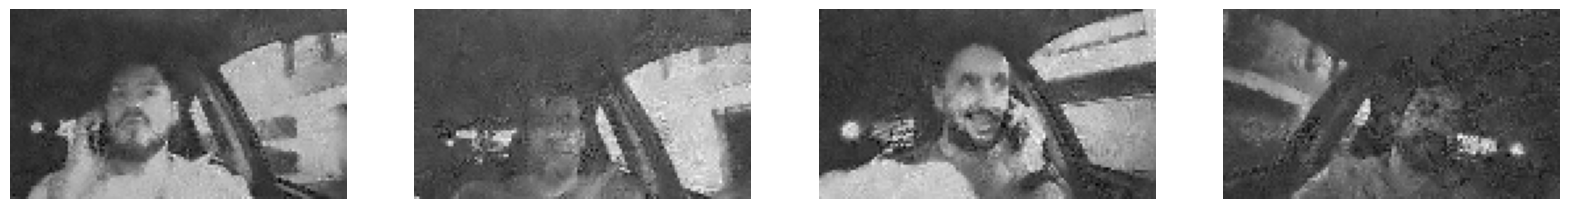

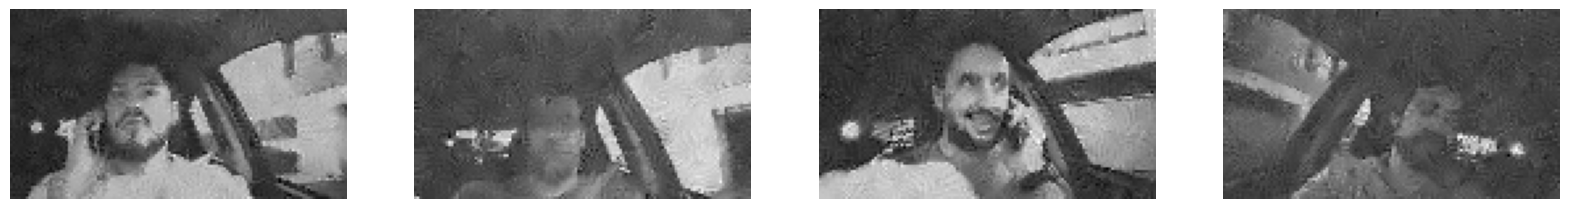

In [31]:
images, labels = next(train_data)
print(images)
images = np.squeeze(images)
print(images.shape)
images = images[:4]

plt.figure(figsize=(20,5))

for i, image in enumerate(images):
    plt.subplot(1,4,i+1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")

# Denoising per patch
sigma_est = np.mean(estimate_sigma(images))
images_denoised = denoise_nl_means(images, h=1.*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)

plt.figure(figsize=(20,5))

for i, image in enumerate(images_denoised):
    plt.subplot(1,4,i+1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")

# Denoising per image
plt.figure(figsize=(20,5))

for i, image in enumerate(images):
    sigma_est = np.mean(estimate_sigma(image))
    image_denoised = denoise_nl_means(image, h=1.*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)
    
    plt.subplot(1,4,i+1)
    plt.imshow(image_denoised, cmap="gray")
    plt.axis("off")

print(type(image_denoised.shape), type(images_denoised.shape))

## Good one

In [61]:
# Collect images and labels from the existing iterator
def extract_data(data_iterator):
    images_list = []
    labels_list = []

    # Iterate through the entire dataset
    for i in range(len(data_iterator)):
        batch_images, batch_labels = data_iterator[i]
        images_list.append(batch_images)
        labels_list.append(batch_labels)

    # Stack the batches into NumPy arrays
    images_array = np.vstack(images_list)
    labels_array = np.vstack(labels_list)
    
    return images_array, labels_array

# Extract the images and labels
train_images, train_labels = extract_data(train_data)
val_images, val_labels = extract_data(val_data)
test_images, test_labels = extract_data(test_data)

print("Train set:", train_images.shape, train_labels.shape)
print("Validation set:", val_images.shape, val_labels.shape)
print("Test set:", test_images.shape, test_labels.shape)

Train set: (11948, 72, 128, 1) (11948, 6)
Validation set: (1922, 72, 128, 1) (1922, 6)
Test set: (985, 72, 128, 1) (985, 6)


In [ ]:
def denoise(img):
    sigma_est = estimate_sigma(img)
    img = denoise_nl_means(img, h=1.*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)
    return img

second_data_gen = ImageDataGenerator(preprocessing_function=denoise)  # Example: without noise or with different augmentation

train_data_aug = second_data_gen.flow(
    train_images, train_labels,
    batch_size=batch_size,
    shuffle=False  # You can control whether to shuffle here
)

val_data_aug = second_data_gen.flow(
    val_images, val_labels,
    batch_size=batch_size,
    shuffle=False
)

test_data_aug = second_data_gen.flow(
    test_images, test_labels,
    batch_size=batch_size,
    shuffle=False
)

C:\Users\lvers\AppData\Local\Temp\ipykernel_21632\2187976121.py:2: UserWarning: image is size 1 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = estimate_sigma(img)


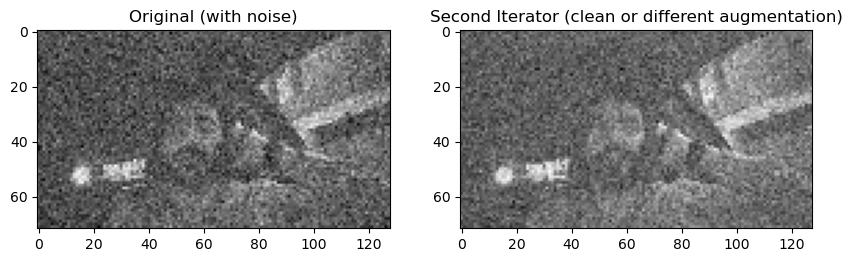

In [65]:
batch_index = 0  # First batch

# Original iterator (without reshuffling the whole dataset)
batch_images_orig, _ = train_data[batch_index]
batch_images_second, _ = second_train_data[batch_index]

# Step 3: Display the same image from both batches
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(batch_images_orig[0], cmap='gray')
plt.title("Original (with noise)")

plt.subplot(1, 2, 2)
plt.imshow(batch_images_second[0], cmap='gray')
plt.title("Second Iterator (clean or different augmentation)")

plt.show()

In [ ]:
batch_nr = 1

for batch_images, batch_labels in train_data:

    print("Processing batch", batch_nr, "of 374")

    batch_images = np.squeeze(batch_images)

    # Denoising
    sigma_est = np.mean(estimate_sigma(batch_images))
    batch_images = denoise_nl_means(batch_images, h=1.*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)
    
    batch_nr += 1

In [ ]:
images_list = []
labels_list = []

for i in range(len(train_data)):
    batch_images, batch_labels = next(train_data)
    batch_images = np.squeeze(batch_images)

    ### Denoising
    for j in range(len(batch_images)):
        sigma_est = estimate_sigma(batch_images[j])
        batch_images[j] = denoise_nl_means(batch_images[j], h=1.*sigma_est, fast_mode=False, 
                                          patch_size=5, patch_distance=3)

    images_list.append(batch_images)
    labels_list.append(batch_labels)

    print("Batch", i, "out of 374 done.")

# Convert to numpy arrays
processed_images = np.vstack(images_list)
processed_labels = np.vstack(labels_list)

# Create a new DataFrame for the processed data
processed_df = pd.DataFrame({
    'img': df_train['img'],  # Use original filenames
    'label': df_train['label']         # Use original labels
})

# Second DataFrameIterator for the processed data
processed_datagen = ImageDataGenerator()
processed_iterator = processed_datagen.flow(
    processed_images, processed_labels, 
    x_col='img',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode="grayscale"
)

Batch 0 out of 374 done.
Batch 1 out of 374 done.
Batch 2 out of 374 done.
Batch 3 out of 374 done.
Batch 4 out of 374 done.
Batch 5 out of 374 done.
Batch 6 out of 374 done.
Batch 7 out of 374 done.
Batch 8 out of 374 done.
Batch 9 out of 374 done.
Batch 10 out of 374 done.
Batch 11 out of 374 done.
Batch 12 out of 374 done.
Batch 13 out of 374 done.
Batch 14 out of 374 done.
Batch 15 out of 374 done.
Batch 16 out of 374 done.
Batch 17 out of 374 done.
Batch 18 out of 374 done.
Batch 19 out of 374 done.
Batch 20 out of 374 done.
Batch 21 out of 374 done.
Batch 22 out of 374 done.
Batch 23 out of 374 done.
Batch 24 out of 374 done.
Batch 25 out of 374 done.
Batch 26 out of 374 done.
Batch 27 out of 374 done.
Batch 28 out of 374 done.
Batch 29 out of 374 done.
Batch 30 out of 374 done.
Batch 31 out of 374 done.
Batch 32 out of 374 done.
Batch 33 out of 374 done.
Batch 34 out of 374 done.
Batch 35 out of 374 done.
Batch 36 out of 374 done.
Batch 37 out of 374 done.
Batch 38 out of 374 do

In [36]:
# Initialize flags
same_images = True
same_labels = True

# Iterate through both iterators
for i in range(len(train_data)):
    batch_images1, batch_labels1 = next(train_data)
    batch_images2, batch_labels2 = next(processed_iterator)

    # Compare images
    if not np.array_equal(batch_images1, batch_images2):
        print(f"Batch {i}: Images are different!")
        same_images = False
    
    # Compare labels
    if not np.array_equal(batch_labels1, batch_labels2):
        print(f"Batch {i}: Labels are different!")
        same_labels = False

# Final check
if same_images and same_labels:
    print("The two DataFrameIterators are identical!")
else:
    print("The two DataFrameIterators are different!")


Batch 0: Images are different!
Batch 0: Labels are different!
Batch 1: Images are different!
Batch 1: Labels are different!
Batch 2: Images are different!
Batch 2: Labels are different!
Batch 3: Images are different!
Batch 3: Labels are different!
Batch 4: Images are different!
Batch 4: Labels are different!
Batch 5: Images are different!
Batch 5: Labels are different!
Batch 6: Images are different!
Batch 6: Labels are different!
Batch 7: Images are different!
Batch 7: Labels are different!
Batch 8: Images are different!
Batch 8: Labels are different!
Batch 9: Images are different!
Batch 9: Labels are different!
Batch 10: Images are different!
Batch 10: Labels are different!
Batch 11: Images are different!
Batch 11: Labels are different!
Batch 12: Images are different!
Batch 12: Labels are different!
Batch 13: Images are different!
Batch 13: Labels are different!
Batch 14: Images are different!
Batch 14: Labels are different!
Batch 15: Images are different!
Batch 15: Labels are differe

In [10]:
# Convert the target testues using the proper function for one hot encoding.
## CONFUSED AS THEY ARE ALREADY IN ONE HOT ENCODING
from tensorflow.keras.utils import to_categorical

# Extract the number of target classes
num_classes = len(np.unique(train_data.classes))

# one-hot encode the integer labels
y_train = to_categorical(train_data.classes, num_classes=num_classes)
y_test = to_categorical(test_data.classes, num_classes=num_classes)
y_test = to_categorical(test_data.classes, num_classes=num_classes)


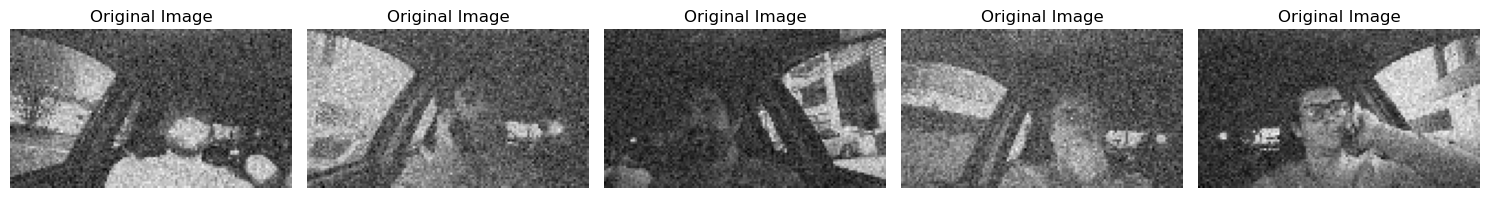

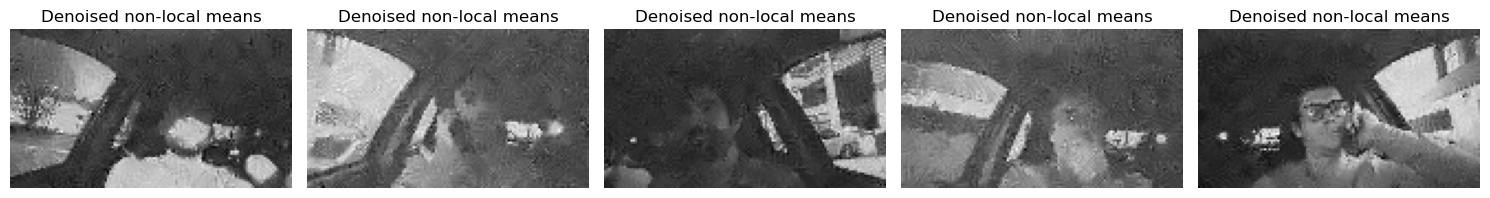

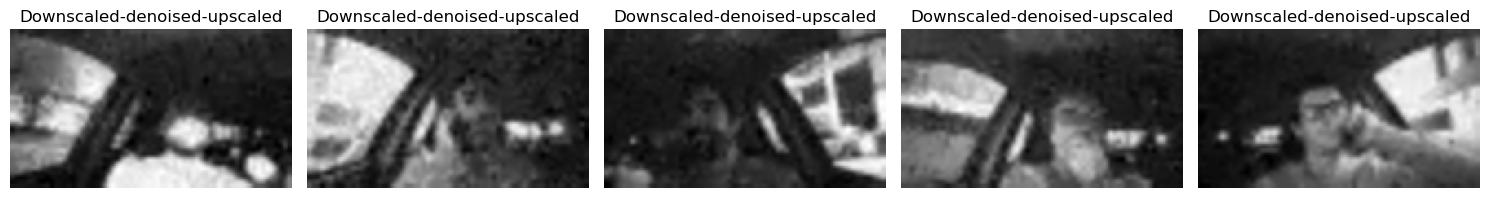

In [11]:
# Randomly select 15 samples from the dataset. For each selected sample, display the image along with its corresponding label as text on top of the image. 
# Arrange 2 these images and labels in a single figure, ensuring that they are visually clear and labeled properly

# Get images and labels from the training data
images, labels = next(train_data)
# images.shape => (32, 72, 128, 1)  # batch_size=32, H=72, W=128, 1=grayscale
# labels.shape => (32, 6)          # one-hot vectors for 6 classes
    
# Randomly select 15 samples
selected_images = images[0:5]

# Create a figure and axes for the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.ravel()

for i in range(len(selected_images)):
    ax = axes[i]
    
    image = selected_images[i]
    image_squeezed = np.squeeze(image) # remove channel dimensions of images

    # ---- Plot the image ----
    ax.imshow(image_squeezed, cmap='gray')
    ax.set_title("Original Image")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create a figure and axes for the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.ravel()

for i in range(len(selected_images)):
    ax = axes[i]
    
    image = selected_images[i]
    image_squeezed = np.squeeze(image) # remove channel dimensions of images
    image_float = img_as_float(image_squeezed)

    # Denoising
    sigma_est = np.mean(estimate_sigma(image_float))
    image_denoised = denoise_nl_means(image_float, h=1.*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)
    
    # ---- Plot the image ----
    ax.imshow(image_denoised, cmap='gray')
    ax.set_title("Denoised non-local means")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create a figure and axes for the images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
axes = axes.ravel()

for i in range(len(selected_images)):
    ax = axes[i]
    
    image = selected_images[i]
    image_squeezed = np.squeeze(image) # remove channel dimensions of images
    image_float = img_as_float(image_squeezed)

    ## Image augmentation

    # Downscaling
    scale_factor = 0.5
    image_downscaled = transform.rescale(image_float, scale_factor, anti_aliasing=True)

    # Denoising
    sigma_est = np.mean(estimate_sigma(image_downscaled))
    image_denoised = denoise_nl_means(image_downscaled, h=0.8*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)
    
    # Upscaling
    image_upscaled = transform.rescale(image_denoised, 1 / scale_factor, anti_aliasing=True)
    
    # ---- Plot the image ----
    ax.imshow(image_upscaled, cmap='gray')
    ax.set_title("Downscaled-denoised-upscaled")
    ax.axis('off')
plt.tight_layout()
plt.show()

## Comparing smoothing filters

In [12]:
images, labels = next(train_data)
img = images[0]
img = np.squeeze(img)
print(img.min(), img.max(), img.dtype)
img = img_as_float(img)
print(img.min(), img.max(), img.dtype)

# --- Step 2: Downsample the noisy image ---
scale_factor = 0.5  # e.g., reduce size by half
img_small = transform.rescale(img, scale_factor, anti_aliasing=True)

# --- Step 3: Denoise the downsampled image using different methods ---

# 1. Non-Local Means (NLM)
sigma_est = np.mean(estimate_sigma(img))
denoised_nlm = denoise_nl_means(img, h=1.15*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)

sigma_est = np.mean(estimate_sigma(img_small))
denoised_nlm_small = denoise_nl_means(img_small, h=1.15*sigma_est, fast_mode=False, 
                                      patch_size=5, patch_distance=3)

# 2. Contrast enhancement
img_adapthist = exposure.equalize_adapthist(img)

# 3. Laplacian filter
laplacian = laplace(img)
alpha = 0.5
minus_sharp = img - alpha * laplacian
plus_laplace = img + alpha * laplacian

# --- Step 4: Upscale the small denoised images back to original resolution ---
denoised_nlm_up = transform.rescale(denoised_nlm_small, 1/scale_factor, anti_aliasing=True)

# --- Step 5: Plot the results ---
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(332)
plt.imshow(img, cmap='gray')
plt.title(f"Original Noisy Image")
plt.axis('off')

# Denoised with Non-Local Means
plt.subplot(334)
plt.imshow(denoised_nlm, cmap='gray')
plt.title("Non-Local Means")
plt.axis('off')

# Denoised with Wavelet
plt.subplot(335)
plt.imshow(img_adapthist, cmap='gray')
plt.title("Adaptive histogram equalization")
plt.axis('off')

# Denoised with Median filter
plt.subplot(336)
plt.imshow(minus_sharp, cmap='gray')
plt.title("Minus Laplacian filter")
plt.axis('off')

# Denoised with Non-Local Means then Upscaled
plt.subplot(337)
plt.imshow(denoised_nlm_up, cmap='gray')
plt.title("Non-Local Means\nDenoised & Upscaled")
plt.axis('off')

# Denoised with Wavelet then Upscaled
plt.subplot(338)
plt.imshow(denoised_wavelet_up, cmap='gray')
plt.title("Wavelet Denoised\n& Upscaled")
plt.axis('off')

# Denoised with Median filter then Upscaled
plt.subplot(339)
plt.imshow(plus_laplace, cmap='gray')
plt.title("Plus Laplacian filter")
plt.axis('off')

plt.tight_layout()
plt.show()


-0.5304003 1.5820509 float32
-0.5304003 1.5820509 float32


ValueError: Images of type float must be between -1 and 1.

## Non-local means denoising

1.342613 -0.2695549 (72, 128)
1.342613 -0.2695549 (72, 128)


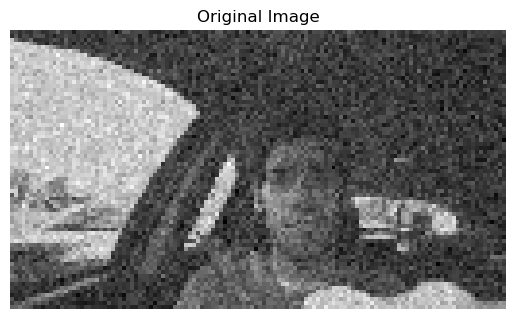

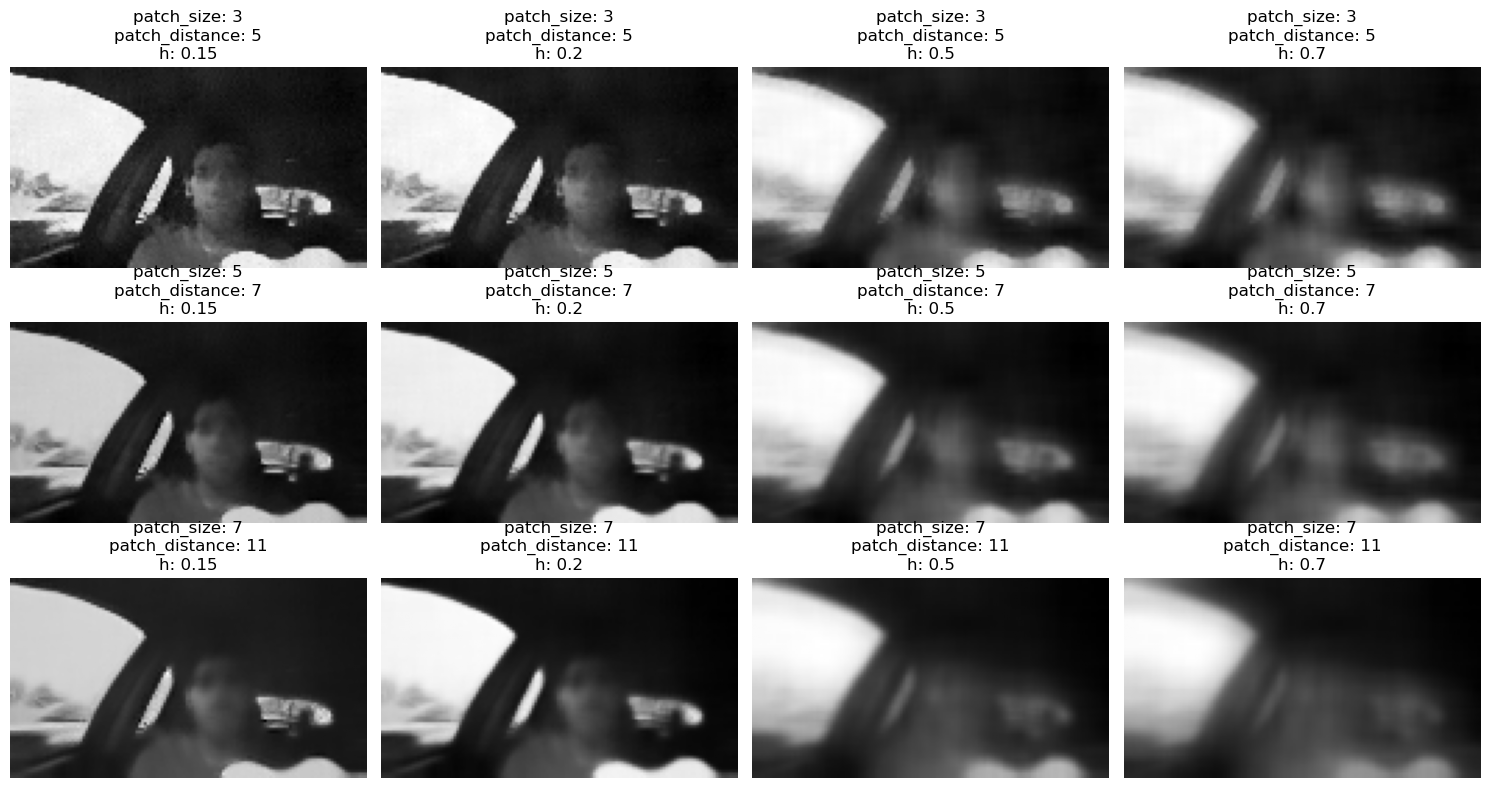

In [ ]:
images, labels = next(train_data)
img = images[0]
img = np.squeeze(img)

print(img.max(), img.min(), img.shape)

img = img_as_float(img)

print(img.max(), img.min(), img.shape)

# --- Step 2: Define different NLM parameter sets ---
# Each dictionary contains parameters for denoise_nl_means
param_list = [
    {"patch_size": 3, "patch_distance": 5, "h": 0.15},
    {"patch_size": 3, "patch_distance": 5, "h": 0.2},
    {"patch_size": 3, "patch_distance": 5, "h": 0.5},
    {"patch_size": 3, "patch_distance": 5, "h": 0.7},
    {"patch_size": 5, "patch_distance": 7, "h": 0.15},
    {"patch_size": 5, "patch_distance": 7, "h": 0.2},
    {"patch_size": 5, "patch_distance": 7, "h": 0.5},
    {"patch_size": 5, "patch_distance": 7, "h": 0.7},
    {"patch_size": 7, "patch_distance": 11, "h": 0.15},
    {"patch_size": 7, "patch_distance": 11, "h": 0.2},
    {"patch_size": 7, "patch_distance": 11, "h": 0.5},
    {"patch_size": 7, "patch_distance": 11, "h": 0.7},
]

denoised_results = []

# --- Step 3: Apply Non-Local Means denoising with each parameter set ---
for params in param_list:
    denoised = denoise_nl_means(
        img,
        patch_size=params["patch_size"],
        patch_distance=params["patch_distance"],
        h=params["h"],
        fast_mode=True,
        channel_axis=None  # None for grayscale images
    )
    denoised_results.append(denoised)

# --- Step 4: Plot the results ---
n_cols = 4
n_rows = int(np.ceil((len(param_list)) / n_cols))

plt.figure()

# Show the noisy image first
plt.imshow(img, cmap='gray')
plt.title(f"Original Image")
plt.axis('off')

plt.figure(figsize=(15, 8))

# Plot each denoised result with its corresponding parameters
for i, params in enumerate(param_list, start=1):
    plt.subplot(n_rows, n_cols, i)
    plt.imshow(denoised_results[i-1], cmap='gray')
    title = (f"patch_size: {params['patch_size']}\n"
             f"patch_distance: {params['patch_distance']}\n"
             f"h: {params['h']}")
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

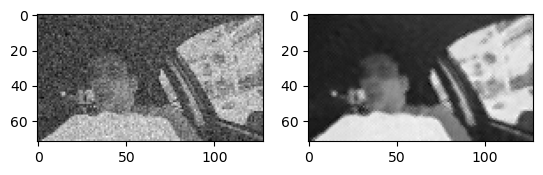

In [63]:
images, labels = next(train_data)
img = images[0]
img = np.squeeze(img)

param_list = {
    "patch_size": [3, 5, 7],
    "patch_distance": [5, 7, 9],
    "h": [0.1, 0.2, 0.5]
}

best_denoiser, params = calibrate_denoiser(img, denoise_nl_means, param_list, extra_output=True)

denoised_img = best_denoiser(img)

plt.subplot(121)
plt.imshow(img, cmap="gray")

plt.subplot(122)
plt.imshow(denoised_img, cmap="gray")

Image has been converted to float
2 (36, 64)
Random noise has been added
Image 1 has been denoised
2 (36, 64)
Denoising has been analysed
1 out of 27 done
Image 2 has been denoised
2 (36, 64)
Denoising has been analysed
2 out of 27 done
Image 3 has been denoised
2 (36, 64)
Denoising has been analysed
3 out of 27 done
Image 4 has been denoised
2 (36, 64)
Denoising has been analysed
4 out of 27 done
Image 5 has been denoised
2 (36, 64)
Denoising has been analysed
5 out of 27 done
Image 6 has been denoised
2 (36, 64)
Denoising has been analysed
6 out of 27 done
Image 7 has been denoised
2 (36, 64)
Denoising has been analysed
7 out of 27 done
Image 8 has been denoised
2 (36, 64)
Denoising has been analysed
8 out of 27 done
Image 9 has been denoised
2 (36, 64)
Denoising has been analysed
9 out of 27 done
Image 10 has been denoised
2 (36, 64)
Denoising has been analysed
10 out of 27 done
Image 11 has been denoised
2 (36, 64)
Denoising has been analysed
11 out of 27 done
Image 12 has been den

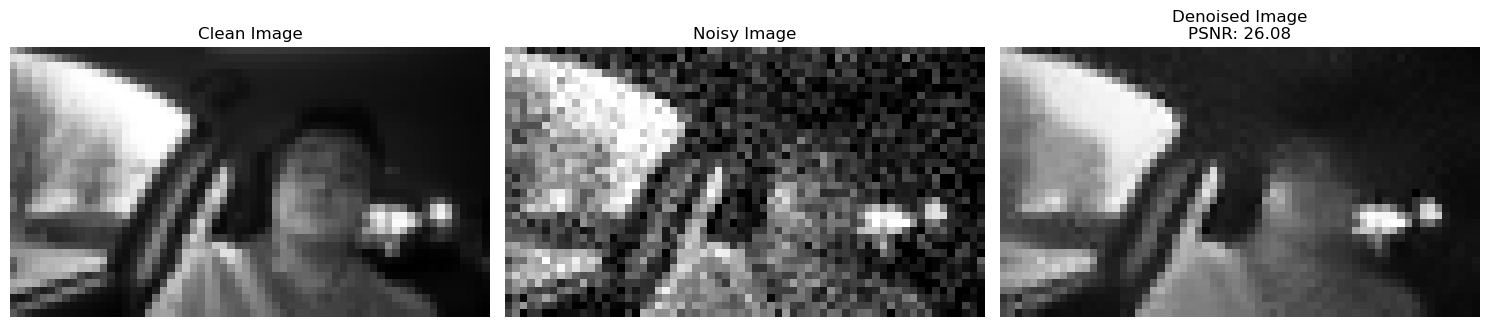

In [40]:
im = io.imread("C:/Users/lvers/OneDrive/Documents/GitHub/Deep_learning_03/driver-inattention-detection-dataset/train/gA_1_s1_ir_face_mp4-1_jpg.rf.054a08cc8325b4f67b3c254e05aae9d2.jpg", 
               as_gray=True)
im = transform.rescale(im, 0.1, anti_aliasing=True)

# Load a clean image and convert it to float [0, 1]
clean_img = img_as_float(im)
print("Image has been converted to float")
print(clean_img.ndim, clean_img.shape)

# Add synthetic Gaussian noise to the clean image
sigma = 0.1  # standard deviation for noise
noisy_img = util.random_noise(clean_img, mode='gaussian', var=sigma**2)
print("Random noise has been added")

# Define the grid of parameters to search over
patch_sizes = [3, 5, 7]
patch_distances = [5, 7, 9]
h_values = [0.1, 0.15, 0.2]

best_params = None
best_psnr = -np.inf
results = []

loop_nr = 1

# Grid search loop
for patch_size in patch_sizes:
    for patch_distance in patch_distances:
        for h in h_values:
            denoised = denoise_nl_means(
                noisy_img,
                patch_size=patch_size,
                patch_distance=patch_distance,
                h=h,
                fast_mode=True,
                channel_axis=None  # None for grayscale images
            )

            print("Image", loop_nr, "has been denoised")
            print(denoised.ndim, denoised.shape)
            
            # Evaluate the denoised image using PSNR against the clean image
            current_psnr = psnr(clean_img, denoised)
            results.append({
                "patch_size": patch_size,
                "patch_distance": patch_distance,
                "h": h,
                "psnr": current_psnr
            })

            print("Denoising has been analysed")
            
            if current_psnr > best_psnr:
                best_psnr = current_psnr
                best_params = {"patch_size": patch_size, "patch_distance": patch_distance, "h": h}

            print(loop_nr, "out of 27 done")
            loop_nr += 1

print("Best Parameters:", best_params)
print("Best PSNR:", best_psnr)

# Optional: Plot the denoised image using the best parameters
best_denoised = denoise_nl_means(
    noisy_img,
    patch_size=best_params["patch_size"],
    patch_distance=best_params["patch_distance"],
    h=best_params["h"],
    fast_mode=True,
    channel_axis=None
)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(clean_img, cmap='gray')
plt.title("Clean Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_img, cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(best_denoised, cmap='gray')
plt.title(f"Denoised Image\nPSNR: {best_psnr:.2f}")
plt.axis('off')
plt.tight_layout()
plt.show()
